# Experimental Data - System Analysis

All needed information for controller design of the system based on experimental data

In [154]:
# Import the needed packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import pandas as pd
import control as cn
import paperfunction as pf

# Set Plot Style
plt.style.use('seaborn-paper')

## System evaluation

Compute the poles and zeros of the multivariable control system.

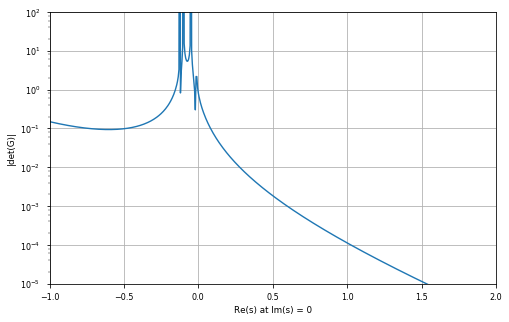

In [155]:
# Get the determinant
detG = lambda s : -0.29/(10.0*s+1.)*np.exp(-1.*s) * -1.75/(20.*s+1)*np.exp(-2.0*s) + .5 / (75. * s + 1.) * np.exp(-2.*s) * 0.625 / (8.0 *s + 1.)* np.exp(-3.0*s)

# Make an array for s
s = np.arange(-1., 4, 0.005)

# Make a figure
plt.clf()
fig, ax = plt.subplots(figsize=(8, 5))
ax.semilogy(s, np.abs(detG(s)))
ax.grid(True)
ax.set_xlabel('Re(s) at Im(s) = 0')
ax.set_ylabel('|det(G)|')
ax.set_ylim([1e-5,1e2])
ax.set_xlim([-1,2])
plt.show()

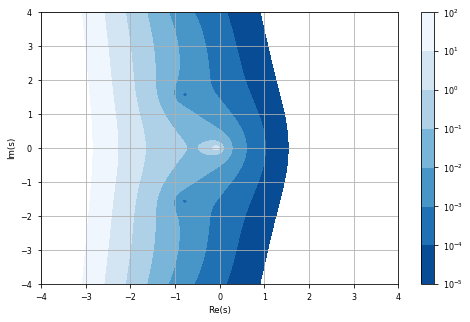

In [156]:
# Get the determinant as an absolute value, complex values as integers
detG = lambda x,y : np.abs(-0.29/(10.0*(x+1j*y)+1.)*np.exp(-1.*(x+1j*y)) * -1.75/(20.*(x+1j*y)+1)*np.exp(-2.0*(x+1j*y)) + .5 / (75. * (x+1j*y) + 1.) * np.exp(-2.*(x+1j*y)) * 0.625 / (8.0 *(x+1j*y) + 1.)* np.exp(-3.0*(x+1j*y)))
# Vectorize the function
detG = np.vectorize(detG)
# Make an quadratic meshgrid
x = np.arange(-4.,4.,0.01)
X,Y = np.meshgrid(x,x)
# Compute the determinant
Z = detG(X,Y)
# Check where the machine precision is reached
loc = np.where(Z< np.finfo(float).eps)

# Plot
plt.clf()
fig, ax = plt.subplots(1,figsize=(8,5))
# Determinant
cs = ax.contourf(X,Y,Z,levels = np.logspace(-5,2,8), norm = colors.LogNorm() , cmap = cm.Blues_r)
cbar = fig.colorbar(cs)
# Machine Precision, remove limits for visibility
ax.scatter(X[loc], Y[loc], color = 'r')
ax.grid(True)
ax.set_xlabel('Re(s)')
ax.set_ylabel('Im(s)')
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])
plt.show()

## Static Decoupling

Next, the model reduction via the dynamic decoupler is performed. The functions are given to be:

$g^*_{S,11} = -\frac{0.29}{10.0~s+1}e^{-1.0s} - \frac{0.5}{1.75}~\frac{0.625}{8.0~s+1}e^{-3.0~s}$

and

$g^*_{S,22} = \frac{-1.75}{20.0~s+1}e^{-2.0s} - \frac{0.625}{0.29}~\frac{0.5}{75.~s+1}e^{-2.0~s}$

The minimum external time delay is given as : $L_{11}^* = 1.$ and $L_{22}^* = 2.$

Which leaves the delay free model:

$g_{11}^+ = -\frac{0.29}{10.0~s+1} + \frac{0.5}{1.75}~\frac{0.625}{8.0~s+1}$

$g^+_{22} = \frac{-1.75}{20.0~s+1} - \frac{0.625}{0.29}~\frac{0.5}{75.~s+1}$

[ 9.23780488] [-0.94344884]


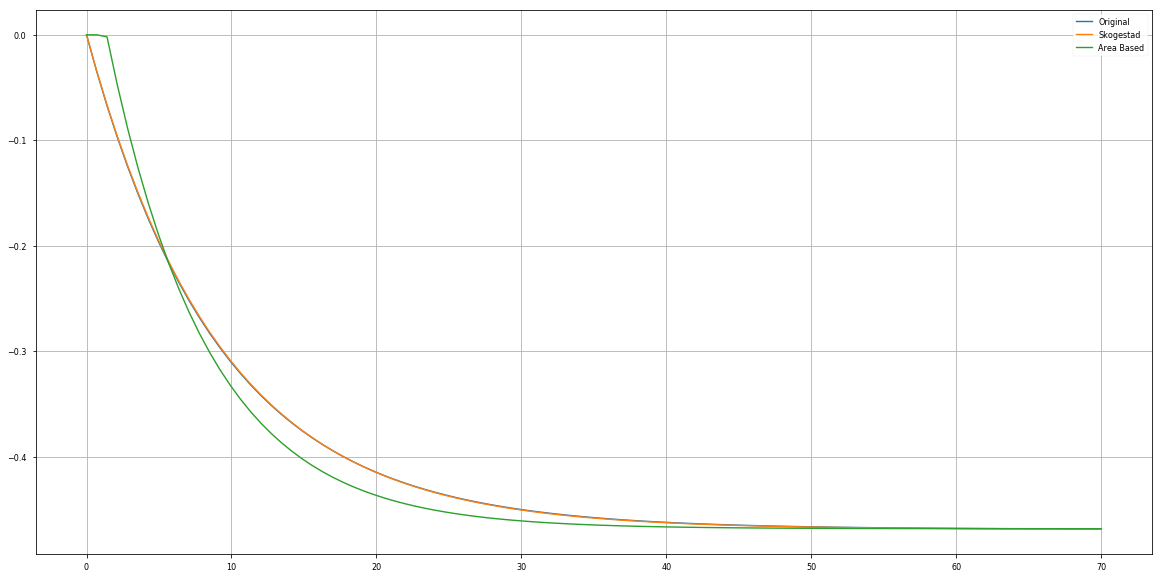

Without Minimal Delay
Skogestad :  -0.468571428571 9.23780487805 0.0
Area :  -0.468088417941 6.90147883911 1.38570670825


In [157]:
# G11
# Get the real , delay free system
g = cn.tf([-0.29],[10.0,1.]) - 0.5 / 1.75 * cn.tf([0.625],[8.,1])
# Get the static gain
K = cn.dcgain(g)[0,0]
# Normalize the transfer function
g_Norm = 1/K * g
# Get the numerator and denominator of the SISO function
num = g_Norm.num[0][0]
den = g_Norm.den[0][0]
# Get the roots, -1/T_1, -1/T_2 ...
num = np.roots(num)
den = np.roots(den)
# Get the Time Constants
num = -1./num
den = -1./den

# Model Approximation via Skogestadt
T,L = pf.MODEL_TO_FOTD(num, den)

y, t = cn.step(g)
yM = pf.Simulate_FOPTD(float(K),float(T),float(L), t)

# Area Identification
k2,t2,l2 = pf.FOTD_AREA_IDENTIFICATION(y,1.,t)
yM2 = pf.Simulate_FOPTD(float(k2),float(t2),float(l2),t)

# Make a plot
plt.clf()
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(t,y, label = "Original")
ax.plot(t,yM, label = "Skogestad")
ax.plot(t,yM2, label = "Area Based")
ax.legend(loc = "upper right")
ax.grid(True)
plt.show()

print("Without Minimal Delay")
print("Skogestad : ", K, T, L)
print("Area : ", k2, t2, l2)

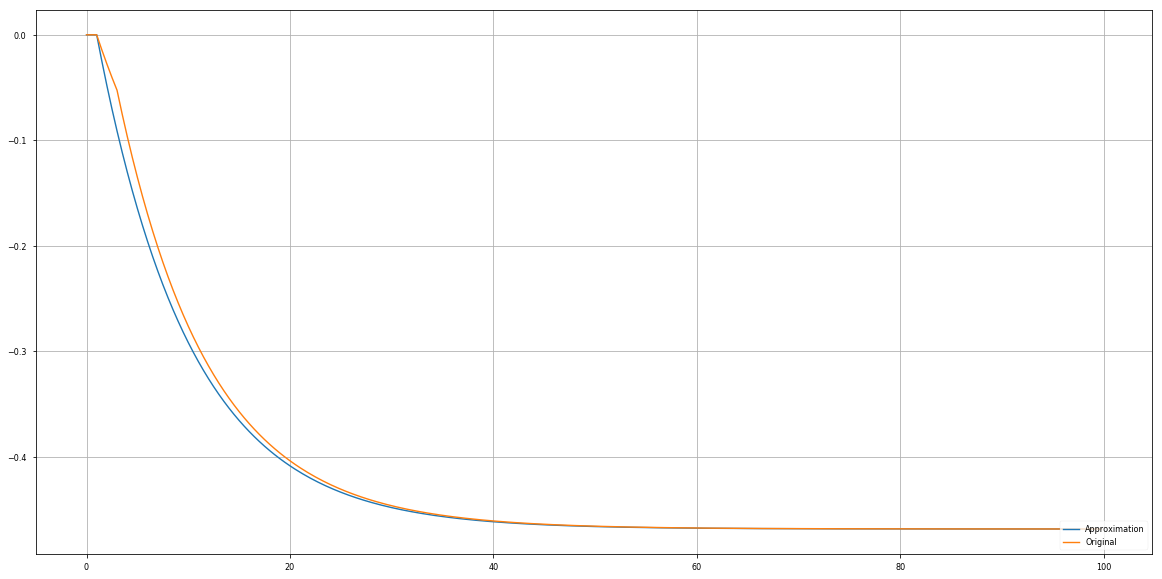

With Minimal Delay
Skogestad :  -0.468571428571 9.23780487805 1.0


In [158]:
# Show the real system response
# Delay free addend
g1 = cn.tf([-0.29],[10.0,1.]) 
g2 = - 0.5 / 1.75 * cn.tf([0.625],[8.,1])
gM = cn.tf(K,[T,1])
# Simulate the step responses with a fixed time
t = np.arange(0, 100, 0.25)
y1, t1 = cn.step(g1, t)
y2, t2 = cn.step(g2, t)
yM, tM = cn.step(gM, t)
# Add the delay, use the same time values 
y1, t = pf.Time_Delay(1., y1, t1, t)
y2, t = pf.Time_Delay(3., y2, t2, t)
yM, t = pf.Time_Delay(L+1., yM, tM, t)

# Plot
plt.clf()
fig, ax = plt.subplots(figsize=(20, 10))
#plt.plot(t,y1, label = "Original 1")
#plt.plot(t,y2, label = "Original 2")
plt.plot(t,yM, label = "Approximation")
plt.plot(t, y1+y2, label = "Original")
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

print("With Minimal Delay")
print("Skogestad : ", K, T, L+1.)
#print("Area : ", k2, t2, l2+1.)

[ 40.96036585] [-713.48318523]


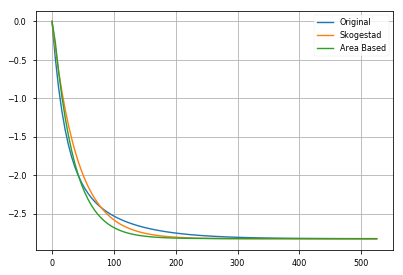

Without Minimal Delay
Skogestad :  -2.8275862069 40.9603658537 0.0
Area :  -2.82469467056 32.8701062095 1.99418470711


In [159]:
# G22
# Get the real , delay free system
g = cn.tf([-1.75],[20.,1.]) - 0.625 / 0.29 * cn.tf([0.5],[75.0,1])
# Get the static gain
K = cn.dcgain(g)[0,0]
# Normalize the transfer function
g_Norm = 1/K * g
# Get the numerator and denominator of the SISO function
num = g_Norm.num[0][0]
den = g_Norm.den[0][0]
# Get the roots, -1/T_1, -1/T_2 ...
num = np.roots(num)
den = np.roots(den)
# Get the Time Constants
num = -1./num
den = -1./den

# Model Approximation via Skogestadt
T,L = pf.MODEL_TO_FOTD(num, den)

y, t = cn.step(g)
yM = pf.Simulate_FOPTD(float(K),float(T),float(L), t)

# Area Identification
k2,t2,l2 = pf.FOTD_AREA_IDENTIFICATION(y,1.,t)
yM2 = pf.Simulate_FOPTD(float(k2),float(t2),float(l2),t)
plt.plot(t,y, label = "Original")
plt.plot(t,yM, label = "Skogestad")
plt.plot(t,yM2, label = "Area Based")
plt.legend(loc = "upper right")
plt.grid(True)
plt.show()

print("Without Minimal Delay")
print("Skogestad : ", K, T, L)
print("Area : ", k2, t2, l2)

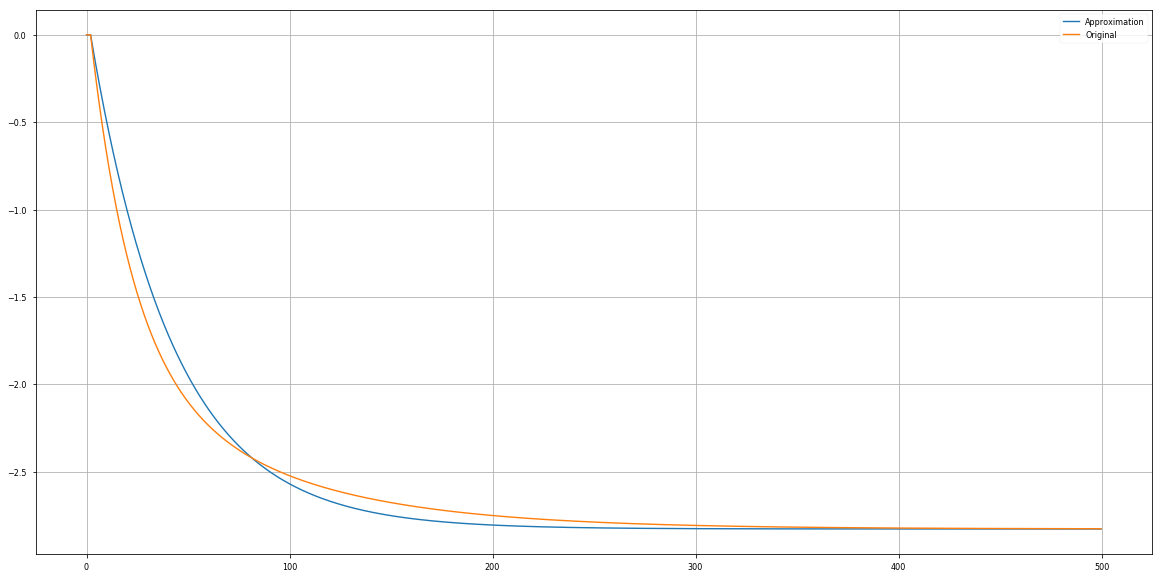

With Minimal Delay
Skogestad :  -2.8275862069 40.9603658537 2.0


In [160]:
# Show the real system response
# Delay free addend
g1 = cn.tf([-1.75],[20.,1.]) 
g2 = - 0.625 / 0.29 * cn.tf([0.5],[75.0,1])
gM = cn.tf(K,[T,1])
# Simulate the step responses with a fixed time
t = np.arange(0, 500, 0.25)
y1, t1 = cn.step(g1, t)
y2, t2 = cn.step(g2, t)
yM, tM = cn.step(gM, t)
# Add the delay, use the same time values 
y1, t = pf.Time_Delay(2., y1, t1, t)
y2, t = pf.Time_Delay(2., y2, t2, t)
yM, t = pf.Time_Delay(L+2., yM, tM, t)

# Plot
plt.clf()
fig, ax = plt.subplots(figsize=(20, 10))
#plt.plot(t,y1, label = "Original 1")
#plt.plot(t,y2, label = "Original 2")
plt.plot(t,yM, label = "Approximation")
plt.plot(t, y1+y2, label = "Original")
plt.legend(loc = "upper right")
plt.grid(True)
plt.show()

print("With Minimal Delay")
print("Skogestad : ", K, T, L+2.)

## Dynamic Decoupling

The transfer functions, with the same external time delay,  are given to be

$g_{11}^+ = -\frac{0.29}{10.0~s+1} + \frac{0.5}{1.75}~\frac{20.0~s+1}{75.0~s+1}~\frac{0.625}{8.0~s+1}$

$g^+_{22} = \frac{-1.75}{20.0~s+1} - \frac{0.625}{0.29}~\frac{10.0~s+1}{8.0~s+1}~\frac{0.5}{75.~s+1}$

[ 30.19817073] [ -914.06133812  7515.52275431]


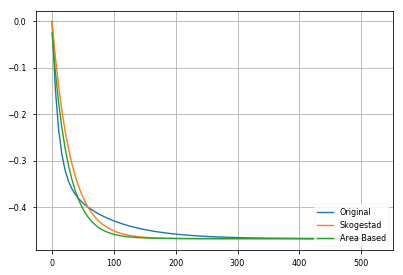

Without Minimal Delay
Skogestad Parameter: -0.468571428571 30.1981707317 0.0
Area Identification Parameter -0.467948629337 25.7888011917 -1.44556552902


In [161]:
# G11
# Get the real , delay free system
g =  cn.tf([-0.29],[10.0,1.]) - 0.5 / 1.75 * cn.tf([0.625],[8.,1]) * cn.tf([20.,1],[75., 1.])
# Get the static gain
K = cn.dcgain(g)[0,0]
# Normalize the transfer function
g_Norm = 1/K * g
# Get the numerator and denominator of the SISO function
num = g_Norm.num[0][0]
den = g_Norm.den[0][0]
# Get the roots, -1/T_1, -1/T_2 ...
num = np.roots(num)
den = np.roots(den)
# Get the Time Constants
num = -1./num
den = -1./den

# Model Approximation via Skogestadt
T,L = pf.MODEL_TO_FOTD(num, den)

y, t = cn.step(g)
yM, tM = cn.step(cn.tf(K,[T,1.]), t)
yM, t = pf.Time_Delay(L, yM,tM,t)

# Area Identification
k2,t2,l2 = pf.FOTD_AREA_IDENTIFICATION(y,1.,t,derivativeCompensation=False)
yM2 = pf.Simulate_FOPTD(float(k2),float(t2),float(l2),t)
plt.plot(t,y, label = "Original")
plt.plot(t,yM, label = "Skogestad")
plt.plot(t,yM2, label = "Area Based")
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

print("Without Minimal Delay")
print("Skogestad Parameter:" ,K,T,L)
print("Area Identification Parameter" ,k2,t2,l2)

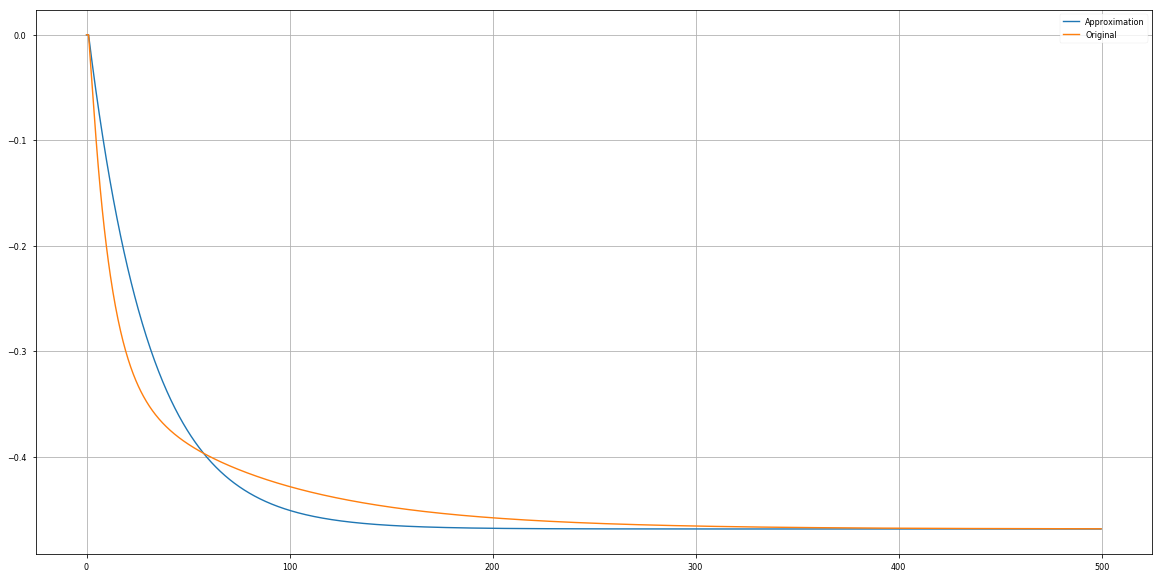

With Minimal Delay
Skogestad :  -0.468571428571 30.1981707317 1.0


In [162]:
# Show the real system response
# Delay free addend
g1 = cn.tf([-0.29],[10.0,1.])
g2 = - 0.5 / 1.75 * cn.tf([0.625],[8.,1]) * cn.tf([20.,1],[75., 1.])
gM = cn.tf(K,[T,1])
# Simulate the step responses with a fixed time
t = np.arange(0, 500, 0.25)
y1, t1 = cn.step(g1, t)
y2, t2 = cn.step(g2, t)
yM, tM = cn.step(gM, t)
# Add the delay, use the same time values 
y1, t = pf.Time_Delay(1., y1, t1, t)
y2, t = pf.Time_Delay(3., y2, t2, t)
yM, t = pf.Time_Delay(L+1., yM, tM, t)

# Plot
plt.clf()
fig, ax = plt.subplots(figsize=(20, 10))
#plt.plot(t,y1, label = "Original 1")
#plt.plot(t,y2, label = "Original 2")
plt.plot(t,yM, label = "Approximation")
plt.plot(t, y1+y2, label = "Original")
plt.legend(loc = "upper right")
plt.grid(True)
plt.show()

print("With Minimal Delay")
print("Skogestad : ", K, T, L+1)

[ 40.19817073] [ -712.0796308   5991.13251041]


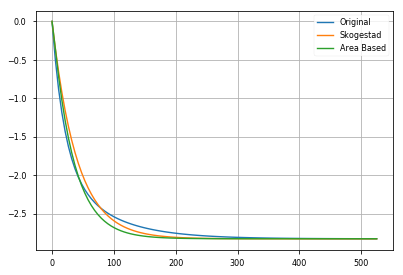

Without Minimal Delay
Skogestad Parameter: -2.8275862069 40.1981707317 0.0
Area Identification Parameter -2.82650253484 33.4081423614 0.855518132726


In [163]:
# G22
# Get the real , delay free system
g = cn.tf([-1.75],[20.,1.]) - 0.625 / 0.29 * cn.tf([0.5],[75.0,1]) * cn.tf([10.,1.],[8.0,1.])
# Get the static gain
K = cn.dcgain(g)[0,0]
# Normalize the transfer function
g_Norm = 1/K * g
# Get the numerator and denominator of the SISO function
num = g_Norm.num[0][0]
den = g_Norm.den[0][0]
# Get the roots, -1/T_1, -1/T_2 ...
num = np.roots(num)
den = np.roots(den)
# Get the Time Constants
num = -1./num
den = -1./den

# Model Approximation via Skogestadt
T,L = pf.MODEL_TO_FOTD(num, den)

y, t = cn.step(g)
yM = pf.Simulate_FOPTD(float(K),float(T),float(L), t)

# Area Identification
k2,t2,l2 = pf.FOTD_AREA_IDENTIFICATION(y,1.,t)
yM2 = pf.Simulate_FOPTD(float(k2),float(t2),float(l2),t)
plt.plot(t,y, label = "Original")
plt.plot(t,yM, label = "Skogestad")
plt.plot(t,yM2, label = "Area Based")
plt.legend(loc = "upper right")
plt.grid(True)
plt.show()

print("Without Minimal Delay")
print("Skogestad Parameter:" ,K,T,L)
print("Area Identification Parameter" ,k2,t2,l2)

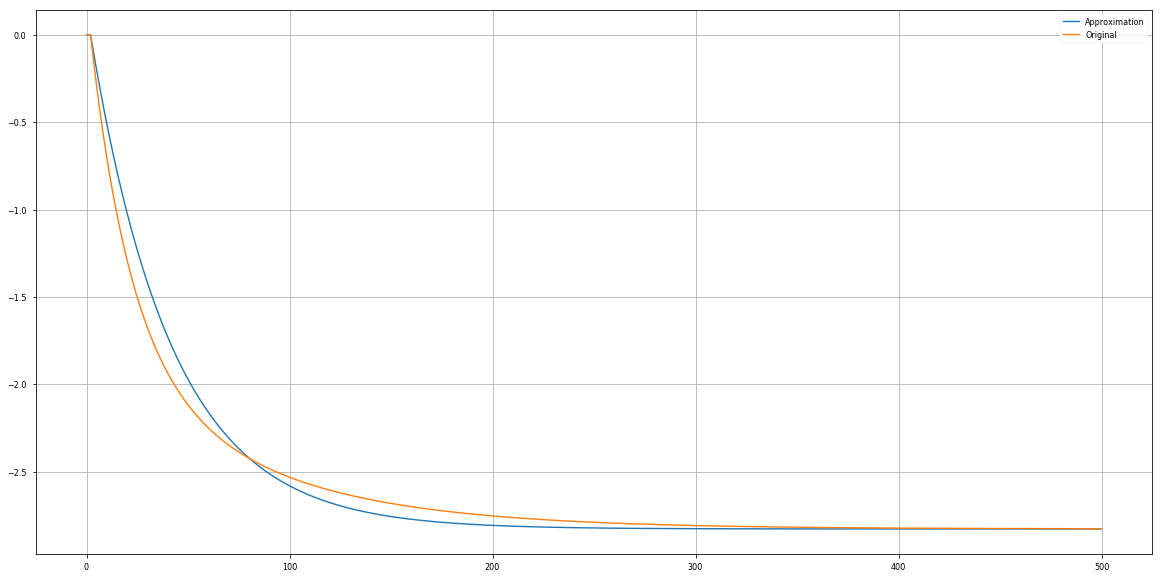

With Minimal Delay
Skogestad Parameter: -2.8275862069 40.1981707317 2.0
Area Identification Parameter -2.82650253484 [  0.00000000e+00   2.50000000e-01   5.00000000e-01 ...,   4.99250000e+02
   4.99500000e+02   4.99750000e+02] 2.85551813273


In [164]:
# Show the real system response
# Delay free addend
g1 = cn.tf([-1.75],[20.,1.]) 
g2 = - 0.625 / 0.29 * cn.tf([0.5],[75.0,1]) * cn.tf([10.,1.],[8.0,1.])
gM = cn.tf(K,[T,1])
# Simulate the step responses with a fixed time
t = np.arange(0, 500, 0.25)
y1, t1 = cn.step(g1, t)
y2, t2 = cn.step(g2, t)
yM, tM = cn.step(gM, t)
# Add the delay, use the same time values 
y1, t = pf.Time_Delay(2., y1, t1, t)
y2, t = pf.Time_Delay(2., y2, t2, t)
yM, t = pf.Time_Delay(L+2., yM, tM, t)

# Plot
plt.clf()
fig, ax = plt.subplots(figsize=(20, 10))
#plt.plot(t,y1, label = "Original 1")
#plt.plot(t,y2, label = "Original 2")
plt.plot(t,yM, label = "Approximation")
plt.plot(t, y1+y2, label = "Original")
plt.legend(loc = "upper right")
plt.grid(True)
plt.show()

print("With Minimal Delay")
print("Skogestad Parameter:" ,K,T,L+2)
print("Area Identification Parameter" ,k2,t2,l2+2)

## Multivariable PI(D) Control

Simplify the determinant, given by:

$det(G) = \frac{0.29 ~ 1.75}{(10.0~s+1) (20.0~s+1)} e^{-3.0~s} + \frac{0.625 ~ 0.5}{(75.0~s+1) (8.0~s+1)} e^{-5.0~s} $

[ 74.1982106] [   39.13219866 -5780.21882249]


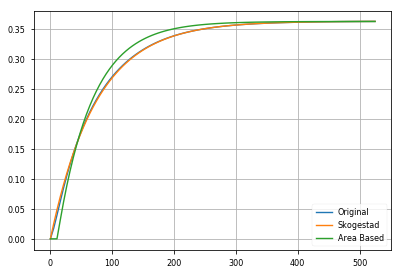

0.36325 74.1982105988 0.0
0.362821806828 55.7137652484 10.9175194646


In [76]:
# G11
# Get the real , delay free system
g =  cn.tf([0.29],[10.0])*cn.tf([1.75],[20.,1.]) + cn.tf([0.625],[75.0,1.])*cn.tf([0.5],[8.,1.])
detG = g
# Get the static gain
K = cn.dcgain(g)[0,0]
# Normalize the transfer function
g_Norm = 1/K * g
# Get the numerator and denominator of the SISO function
num = g_Norm.num[0][0]
den = g_Norm.den[0][0]
# Get the roots, -1/T_1, -1/T_2 ...
num = np.roots(num)
den = np.roots(den)
# Get the Time Constants
num = -1./num
den = -1./den

# Model Approximation via Skogestadt
T,L = pf.MODEL_TO_FOTD(num, den)

y, t = cn.step(g)
yM, tM = cn.step(cn.tf(K,[T,1.]), t)
yM, t = pf.Time_Delay(L, yM,tM,t)

# Area Identification
k2,t2,l2 = pf.FOTD_AREA_IDENTIFICATION(y,1.,t,derivativeCompensation=False)
yM2 = pf.Simulate_FOPTD(float(k2),float(t2),float(l2),t)
plt.plot(t,y, label = "Original")
plt.plot(t,yM, label = "Skogestad")
plt.plot(t,yM2, label = "Area Based")
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

print(K,T,L)
print(k2,t2,l2)

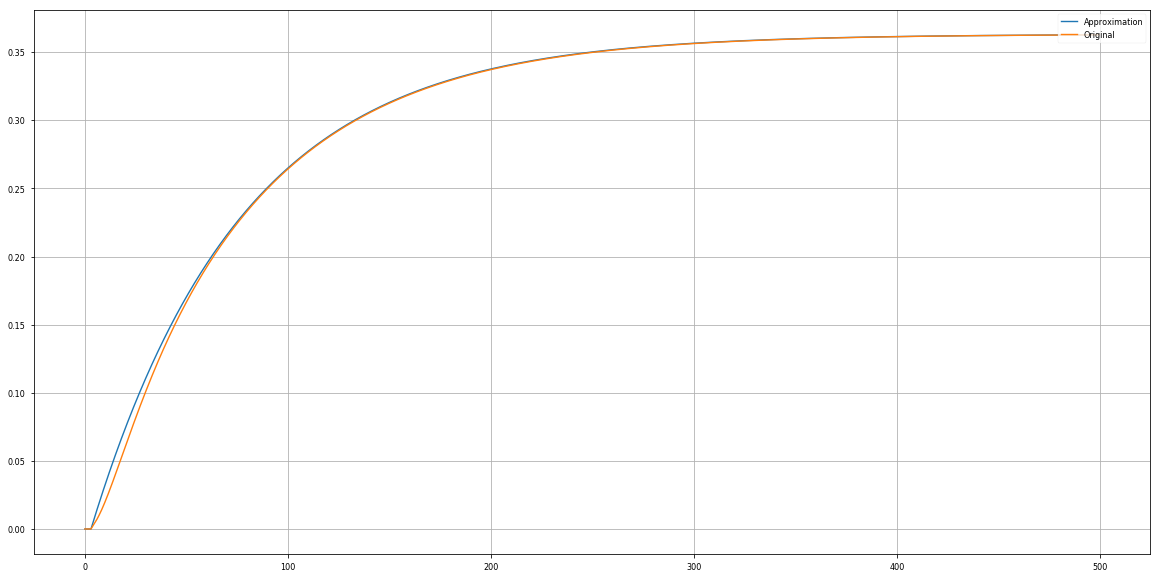

0.36325 74.1982105988 3.0


In [77]:
# Show the real system response
# Delay free addend
g1 =  cn.tf([0.29],[10.0])*cn.tf([1.75],[20.,1.])
g2 =  cn.tf([0.625],[75.0,1.])*cn.tf([0.5],[8.,1.])
gM = cn.tf(K,[T,1])
# Simulate the step responses with a fixed time
t = np.arange(0, 500, 0.25)
y1, t1 = cn.step(g1, t)
y2, t2 = cn.step(g2, t)
yM, tM = cn.step(gM, t)
# Add the delay, use the same time values 
y1, t = pf.Time_Delay(3., y1, t1, t)
y2, t = pf.Time_Delay(5., y2, t2, t)
yM, t = pf.Time_Delay(L+3., yM, tM, t)

# Plot
plt.clf()
fig, ax = plt.subplots(figsize=(20, 10))
#plt.plot(t,y1, label = "Original 1")
#plt.plot(t,y2, label = "Original 2")
plt.plot(t,yM, label = "Approximation")
plt.plot(t, y1+y2, label = "Original")
plt.legend(loc = "upper right")
plt.grid(True)
plt.show()
print(K,T,L+3.)

Compute the controller given by:

$k_{ij} = \frac{k_{ii}}{s}e^{-L_{C,ii}~s} (\frac{det(G)}{Adj(G)_{ij}})$

1 states have been removed from the model
[] [  54.1982106  -516.17343427]


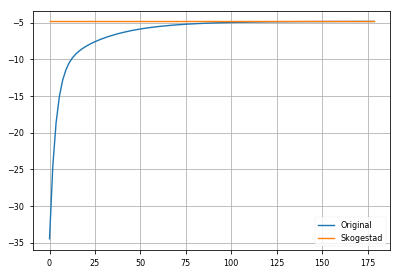

-4.81761871989 0.0 3.0


In [86]:
# k11
g = cn.matlab.minreal(cn.tf([-1.75],[20.,1.]) / detG )
# Get the static gain
K = cn.dcgain(g)[0,0]
# Normalize the transfer function
g_Norm = 1/K * g
# Get the numerator and denominator of the SISO function
num = g_Norm.num[0][0]
den = g_Norm.den[0][0]
# Get the roots, -1/T_1, -1/T_2 ...
num = np.roots(num)
den = np.roots(den)
# Get the Time Constants
num = -1./num
den = -1./den
# Model Approximation via Skogestadt
T,L = pf.MODEL_TO_FOTD(num, den)
y, t = cn.step(g)
yM, tM = cn.step(cn.tf(K,[T,1.]), t)
yM, t = pf.Time_Delay(L, yM,tM,t)

plt.plot(t,y, label = "Original")
plt.plot(t,yM, label = "Skogestad")
#plt.plot(t,yM2, label = "Area Based")
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

print(K,T,L+3)

1 states have been removed from the model
[] [   66.1982106  -1416.17343427]


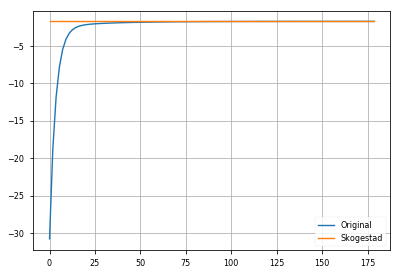

-1.72057811425 0.0 3.0


In [87]:
# k12
g = cn.matlab.minreal(cn.tf([-0.625],[8.,1.]) / detG )
# Get the static gain
K = cn.dcgain(g)[0,0]
# Normalize the transfer function
g_Norm = 1/K * g
# Get the numerator and denominator of the SISO function
num = g_Norm.num[0][0]
den = g_Norm.den[0][0]
# Get the roots, -1/T_1, -1/T_2 ...
num = np.roots(num)
den = np.roots(den)
# Get the Time Constants
num = -1./num
den = -1./den
# Model Approximation via Skogestadt
T,L = pf.MODEL_TO_FOTD(num, den)
y, t = cn.step(g)
yM, tM = cn.step(cn.tf(K,[T,1.]), t)
yM, t = pf.Time_Delay(L, yM,tM,t)

plt.plot(t,y, label = "Original")
plt.plot(t,yM, label = "Skogestad")
#plt.plot(t,yM2, label = "Area Based")
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

print(K,T,L+3)

1 states have been removed from the model
[] [ -0.8017894  -76.17343427]


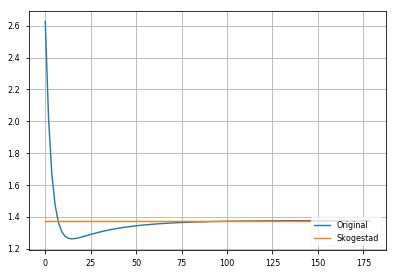

1.3764624914 0.0 3.0


In [88]:
# k21
g = cn.matlab.minreal(cn.tf([.5],[75.,1.]) / detG )
# Get the static gain
K = cn.dcgain(g)[0,0]
# Normalize the transfer function
g_Norm = 1/K * g
# Get the numerator and denominator of the SISO function
num = g_Norm.num[0][0]
den = g_Norm.den[0][0]
# Get the roots, -1/T_1, -1/T_2 ...
num = np.roots(num)
den = np.roots(den)
# Get the Time Constants
num = -1./num
den = -1./den
# Model Approximation via Skogestadt
T,L = pf.MODEL_TO_FOTD(num, den)
y, t = cn.step(g)
yM, tM = cn.step(cn.tf(K,[T,1.]), t)
yM, t = pf.Time_Delay(L, yM,tM,t)

plt.plot(t,y, label = "Original")
plt.plot(t,yM, label = "Skogestad")
#plt.plot(t,yM2, label = "Area Based")
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

print(K,T,L+3)

0 states have been removed from the model
[] [    64.1982106   -1888.15554026  11161.73434274]


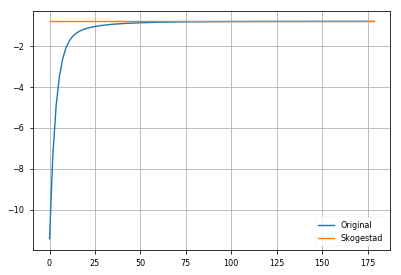

-0.79834824501 0.0 3.0


In [89]:
# k22
g = cn.matlab.minreal(cn.tf([-0.29],[10.,1.]) / detG )
# Get the static gain
K = cn.dcgain(g)[0,0]
# Normalize the transfer function
g_Norm = 1/K * g
# Get the numerator and denominator of the SISO function
num = g_Norm.num[0][0]
den = g_Norm.den[0][0]
# Get the roots, -1/T_1, -1/T_2 ...
num = np.roots(num)
den = np.roots(den)
# Get the Time Constants
num = -1./num
den = -1./den
# Model Approximation via Skogestadt
T,L = pf.MODEL_TO_FOTD(num, den)
y, t = cn.step(g)
yM, tM = cn.step(cn.tf(K,[T,1.]), t)
yM, t = pf.Time_Delay(L, yM,tM,t)

plt.plot(t,y, label = "Original")
plt.plot(t,yM, label = "Skogestad")
#plt.plot(t,yM2, label = "Area Based")
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

print(K,T,L+3)

As can be seen from the model approximation, all simplified models have either a direct feedthrough and/or a strong DT-behaviour. Hence, the simplified models are not feasable for PI(D) reduction.

## Simulation

Simulate the dymola systems via the interface.

In [138]:
# General Information

# Modelica Package name
Package = "Experimental"

# Make an array of models to automate the evaluation Centralized_PID  does not work
models = ['Ideal','Decentralized', 'Static_Decoupling', 'Dynamic_Decoupling', 'Inverse_Decoupling']

# Model to simulate, here the folder and the modelica file containing the model needs to be specified.
Model_Path = "../Modelica/Experimental.mo"

# Simulation Parameter, here the simulation parameter have to be specified.
sim_parameter = {
    "stopTime" : 4600,
    "Intervals": 1e2,
    "OutputInterval" : 1,
    "Stepsize" : 1,
    "finalNames" : ["y_1","y_2","u_1","u_2", "IAE_1.y", "IAE_2.y", "IE_1", "IE_2"],
}


### System Analysis

Analyze the system without gains.

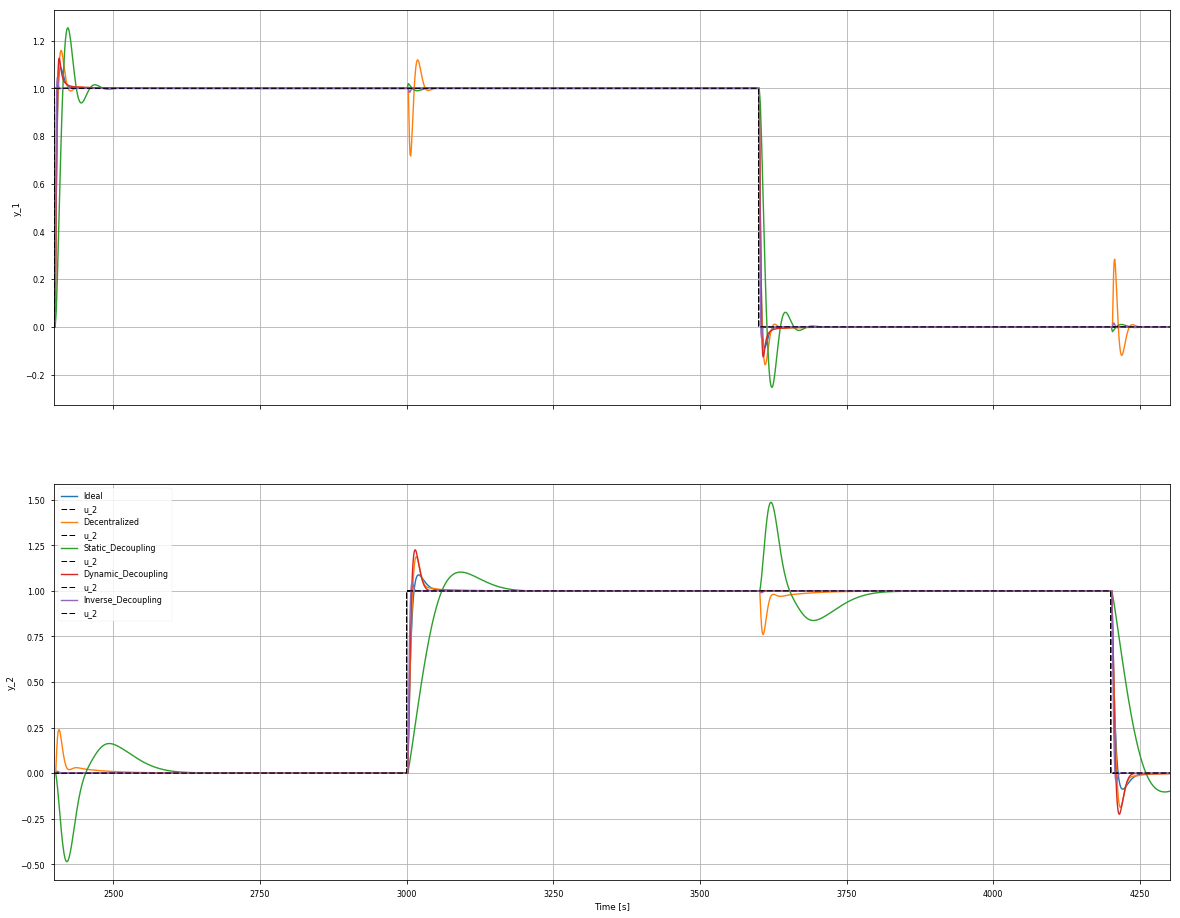

In [139]:
# Initialize the model
model = pf.Initialize_Simulation("../Modelica/"+Package+".mo", Show = False)

# Make a plot
plt.clf()
fig, ax = plt.subplots(2, sharex = True, figsize = (20,16))

# Loop over all models in the modelica file
for model_names in models:

    # Update the simulation parameter
    sim_parameter.update({"Model":Package+"."+model_names, "Result": "../Data/"+Package+"/"+model_names})
    # Run the current simulation
    pf.Run_Simulation(model, sim_parameter)
    # Get the result data
    Data = pf.Simulation_Results("../Data/"+Package+"/"+model_names+".mat")
    # Apply the data to the plot
    ax[0].plot(Data["time"], Data["y_1"], label = model_names)
    ax[0].plot(Data["time"], Data["u_1"], color = 'k', linewidth = 1, linestyle = 'dashed', label = None)
    
    ax[1].plot(Data["time"], Data["y_2"], label = model_names)
    ax[1].plot(Data["time"], Data["u_2"], color = 'k', linewidth = 1, linestyle = 'dashed', label = None)

# Close the current simulation instance
model.close()

# Add the layout to the plot
ax[1].legend()
ax[0].set_ylabel('y_1')
ax[0].grid(True)
ax[1].set_ylabel('y_2')
ax[1].set_xlabel('Time [s]')
ax[1].grid(True)
ax[0].set_xlim([2399,4301])
plt.show()

### Gain Study for Decentralized system

Decentralized controlled system;

Steps to be taken:
- Get the system behaviour without additional gain
- Amplify every gain K_11 / K_22 individually until the closed loop collapses
- Amplify both gains until the closed loop collapses

In [140]:
# Gain Increment and maximum Gain
dK = .1
KMax = 1.2

# Initialize the model
model = pf.Initialize_Simulation("../Modelica/"+Package+".mo")

# Make a list for gain storage
maximum_gains = {}

# Loop over all models in the modelica file except "Ideal"
for model_names in models[1:]:
    
    # Inner loop, increase the gain of u_1
    # Make the gains
    K = 1.
    # Start with stable system
    stability = True
    
    while stability:
        # Increase the gain
        if (K < KMax):
            K = K + dK
        else:
            break
        # Update the simulation parameter
        sim_parameter.update({"Model":Package+"."+model_names, "Result": "../Data/"+Package+"/"+model_names+"_K11"})
        sim_parameter.update({"initialNames":["K_11.k", "K_22.k"], "initialValues":[K,1.]})
        # Simulate the model
        pf.Run_Simulation(model, sim_parameter)
        # Load the results
        Data = pf.Simulation_Results("../Data/"+Package+"/"+model_names+"_K11.mat")
        # Check the stability
        stability = pf.Stability(Data["y_1"].values,Data["u_1"].values) and pf.Stability(Data["y_2"].values,Data["u_2"].values)


    # Get the last stable gain
    maximum_gains.update({model_names+"_K11" : K-dK})
    
    # Inner loop, increase the gain of u_2
    # Make the gains
    K = 1.
    # Start with stable system
    stability = True
    
    while stability:
        # Increase the gain
        if (K < KMax):
            K = K + dK
        else:
            break
        # Update the simulation parameter
        sim_parameter.update({"Model":Package+"."+model_names, "Result": "../Data/"+Package+"/"+model_names+"_K22"})
        sim_parameter.update({"initialNames":["K_11.k", "K_22.k"], "initialValues":[1.,K]})
        # Simulate the model
        pf.Run_Simulation(model, sim_parameter)
        # Load the results
        Data = pf.Simulation_Results("../Data/"+Package+"/"+model_names+"_K22.mat")
        # Check the stability
        stability = pf.Stability(Data["y_1"].values,Data["u_1"].values) and pf.Stability(Data["y_2"].values,Data["u_2"].values)
    # Get the last stable gain
    maximum_gains.update({model_names+"_K22" : K-dK})

# Close the model
model.close()    

0

In [141]:
maximum_gains

{'Decentralized_K11': 1.1,
 'Decentralized_K22': 1.1,
 'Dynamic_Decoupling_K11': 1.1,
 'Dynamic_Decoupling_K22': 1.1,
 'Inverse_Decoupling_K11': 1.1,
 'Inverse_Decoupling_K22': 1.1,
 'Static_Decoupling_K11': 1.0,
 'Static_Decoupling_K22': 1.0}